In [3]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

(examples:hrtem_quickstart)=
# HRTEM quickstart
This notebook demonstrates a basic HRTEM simulation of a double-walled carbon nanotube.

## Configuration

We start by setting our configuration. See documentation for details.

In [ ]:
abtem.config.set(device="cpu")
abtem.config.set(fft="fftw")

## Atomic model

In this section we create the atomic model, you can modify this simulation by swapping in your own atomic model. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

We create two nanotubes with different radii using the `nanotube` function from ASE.

In [54]:
tube1 = ase.build.nanotube(10, 0, length=5)

tube2 = ase.build.nanotube(16, 0, length=5)

tube1.rotate("z", 30) # rotate one of the nanotubes

tubes = tube1 + tube2 # combine the two nanotubes into a single structure

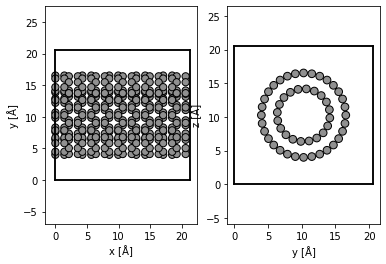

In [55]:
tubes.rotate("y", 90, rotate_cell=True)

tubes.center(vacuum=4.0, axis=(0, 1))

tubes.pbc = True

tubes = abtem.standardize_cell(tubes)

tubes.wrap()

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(tubes, plane="xy", ax=ax1)
abtem.show_atoms(tubes, plane="yz", ax=ax2);

## Potential

We create an ensemble of potentials using the frozen phonon. See our [walkthrough](walkthrough:frozen_phonons) on frozen phonons. 

In [72]:
frozen_phonons = abtem.FrozenPhonons(tubes, 16, sigmas=0.06)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [73]:
potential = abtem.Potential(
    frozen_phonons, sampling=.05, projection="infinite", slice_thickness=0.5,
)

## Wave function

We create a plane wave function at an energy of 100 keV. See our [walkthrough on wave functions](walkthrough:wave_functions). 

In [74]:
wave = abtem.PlaneWave(energy=100e3)

## Multislice

We run the multislice algorithm and calculate the diffraction patterns, see our [walkthrough on multislice](walkthrough:multislice).

In [75]:
exit_wave = wave.multislice(potential)

In [76]:
exit_wave.compute()

[########################################] | 100% Completed |  9.8s


## Contrast transfer function

In [77]:
Cs = -8e-6 * 1e10  # spherical aberration (-8 um)
Cc = 1.2e-3 * 1e10 # chromatic aberration (1.2 mm)
energy_spread = 0.35 # standard deviation energy spread (0.35 eV)

focal_spread = Cc * energy_spread / exit_wave.energy 

ctf = abtem.CTF(Cs=Cs, energy=wave.energy)
ctf.defocus = ctf.scherzer_defocus
ctf.semiangle_cutoff = ctf.crossover_angle
ctf.focal_spread = focal_spread

print(f"defocus = {ctf.defocus:.2f} Å")

defocus = -66.65 Å


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='k [1 / Å]'>)

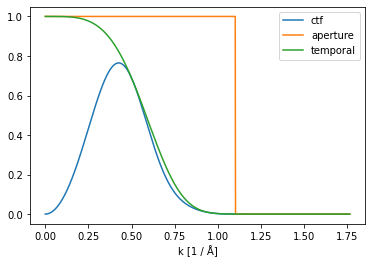

In [78]:
ctf.profiles().show()

(<Figure size 432x288 with 2 Axes>, <Axes:xlabel='x [Å]', ylabel='y [Å]'>)

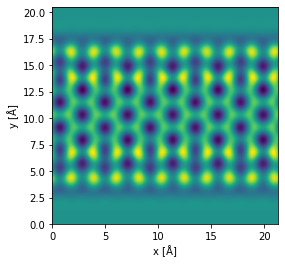

In [79]:
measurement = exit_wave.apply_ctf(ctf).intensity().mean(0)

measurement.show()

## Postprocessing

(<Figure size 432x288 with 2 Axes>, <Axes:xlabel='x [Å]', ylabel='y [Å]'>)

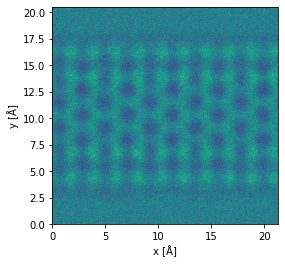

In [81]:
noisy_measurement = measurement.poisson_noise(1e4)

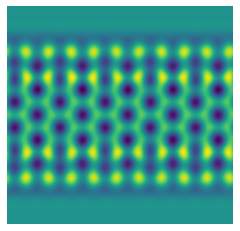

In [66]:
# this cell produces a thumbnail for the online documentation

fig, ax = measurement.show()
ax.axis("off")
plt.savefig("../thumbnails/hrtem_quickstart.png", bbox_inches="tight", pad_inches=0)